

```
# This is formatted as code
```

# CMPT 742 - Fall 2025
# Object detection with YOLO

__content creator:__ Aryan Mikaeili

In [2]:
#@title Import libraries

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.ops import batched_nms
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import numpy as np
from PIL import Image
import cv2
import pandas as pd
from tqdm import tqdm

In [3]:
#@title Utils

def convert_cellboxes(boxes):
    #boxes: torch tensor (B, S, S, 30)
    bboxes1 = boxes[..., 21:25]
    bboxes2 = boxes[..., 26:30]
    scores = torch.cat((boxes[..., 20].unsqueeze(0), boxes[..., 25].unsqueeze(0)), dim = 0)
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    x_cell, y_cell = best_boxes[..., 0:1], best_boxes[..., 1:2]
    width_cell, height_cell = best_boxes[..., 2:3], best_boxes[..., 3:4]

    cell_indices = torch.arange(7).repeat(7, 1).unsqueeze(-1).to(boxes.device)

    x = (x_cell + cell_indices) / 7
    y = (y_cell + cell_indices.permute(1, 0, 2)) / 7

    width = width_cell / 7
    height = height_cell / 7

    converted_boxes = torch.cat((x, y, width, height), dim = -1)
    predicted_class = boxes[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(boxes[..., 20], boxes[..., 25]).unsqueeze(-1)

    converted_pred = torch.cat((predicted_class, best_confidence, converted_boxes), dim = -1)

    return converted_pred

def cellboxes_to_boxes(boxes, S = 7):
    #boxes: torch tensor (B, S, S, 30)
    converted_pred = convert_cellboxes(boxes)

    B = converted_pred.size(0)

    all_bboxes = converted_pred.reshape(B, S * S, -1)

    return all_bboxes

def non_max_suppression(bboxes, iou_threshold = 0.5, confidence_threshold = 0.4):
    #bboxes: (N, 6)
    #boxes: (N, 6) -> (N2, 4)

    #prune boxes that have confidence < threshold
    bboxes = bboxes[bboxes[:, 1] > confidence_threshold]
    bboxes_coords = bboxes[:, 2:6]
    scores = bboxes[:, 1]
    class_bboxes = bboxes[:, 0]

    # convert xywh to x1y1x2y2
    x1 = bboxes_coords[:, 0] - bboxes_coords[:, 2] / 2
    y1 = bboxes_coords[:, 1] - bboxes_coords[:, 3] / 2
    x2 = bboxes_coords[:, 0] + bboxes_coords[:, 2] / 2
    y2 = bboxes_coords[:, 1] + bboxes_coords[:, 3] / 2

    bboxes_coords = torch.stack((x1, y1, x2, y2)).T

    keep = batched_nms(bboxes_coords, scores, class_bboxes, iou_threshold=iou_threshold)

    return bboxes[keep]

def visualize_images(images, row_size):
    #images: list of PIL images
    #row_size: number of images per row
    #returns: PIL image

    num_images = len(images)
    col_size = num_images // row_size
    if num_images % row_size != 0:
        col_size += 1

    image_size = images[0].size[0]
    canvas = Image.new('RGB', (image_size * row_size, image_size * col_size))
    for i, image in enumerate(images):
        canvas.paste(image, (image_size * (i % row_size), image_size * (i // row_size)))
    return canvas

def draw_boxes(image, gt_boxes, pred_boxes):
    image = ((image.permute(1, 2, 0).cpu().detach().numpy() + 1) * 127.5).astype('uint8')
    image_pred = image.copy()
    image_gt = image.copy()
    for box in gt_boxes:
        x, y, w, h = box[3:]
        x1 = int((x - w / 2) * 448)
        y1 = int((y - h / 2) * 448)
        x2 = int((x + w / 2) * 448)
        y2 = int((y + h / 2) * 448)

        image_gt = cv2.rectangle(image_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)

    for box in pred_boxes:
        x, y, w, h = box[3:]
        x1 = int((x - w / 2) * 448)
        y1 = int((y - h / 2) * 448)
        x2 = int((x + w / 2) * 448)
        y2 = int((y + h / 2) * 448)

        image_pred = cv2.rectangle(image_pred, (x1, y1), (x2, y2), (0, 0, 255), 2)

    image_gt = Image.fromarray(image_gt)
    image_pred = Image.fromarray(image_pred)

    image = visualize_images([image_gt, image_pred], 2)

    return image

def draw_boxes_with_labels(image, pred_labels, gt_labels, pred_classes, gt_classes):
    image = ((image.permute(1, 2, 0).cpu().detach().numpy() + 1) * 127.5).astype('uint8')
    image_pred = image.copy()
    image_gt = image.copy()
    for i, box in enumerate(gt_labels):
        x, y, w, h = box[3:]
        x1 = int((x - w / 2) * 448)
        y1 = int((y - h / 2) * 448)
        x2 = int((x + w / 2) * 448)
        y2 = int((y + h / 2) * 448)

        image_gt = cv2.rectangle(image_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_gt, gt_classes[i], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 255, 0), 2)

    for i, box in enumerate(pred_labels):
        x, y, w, h = box[3:]
        x1 = int((x - w / 2) * 448)
        y1 = int((y - h / 2) * 448)
        x2 = int((x + w / 2) * 448)
        y2 = int((y + h / 2) * 448)

        image_pred = cv2.rectangle(image_pred, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(image_pred, pred_classes[i], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (0, 0, 255), 2)

    image_gt = Image.fromarray(image_gt)
    image_pred = Image.fromarray(image_pred)
    image = visualize_images([image_gt, image_pred], 2)

    return image



In [15]:
#@title TODO: Intersection over Union (15 minutes)

def intersection_over_union(boxes_preds, boxes_labels, box_format = 'midpoint'):
    # boxes_preds: (..., 4)
    # boxes_labels: (..., 4)
    #box format: format of input boxes
    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    else:
        raise ValueError('Unknown box format.')

    #TODO: find (x1, y1) and (x2, y2) of
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    #TODO: find intersection area
    intersection = torch.clamp(x2-x1, 0) * torch.clamp(y2-y1, 0)

    #TODO: find union area
    union = torch.abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1)) + \
            torch.abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1)) - \
            intersection

    return intersection / (union + 1e-6)

In [16]:
#@title Check IoU implementation

boxes1 = torch.tensor([[0.5, 0.5, 0.6, 0.3], [0.2, 0.2, 0.1, 0.1]])
boxes2 = torch.tensor([[0.5, 0.5, 0.3, 0.6], [0.6, 0.6, 0.2, 0.3]])
assert (torch.abs(intersection_over_union(boxes1,  boxes2).reshape(2, ) - torch.tensor([0.3333, 0.])) < 1e-4).all()

# Download and config dataset

In [17]:
#@title Download dataset

import zipfile

!gdown --id 1HIPUz1aguNp8RTSx_H-f7z9_OHOu35n5

zip_file = zipfile.ZipFile('small_data.zip')
zip_file.extractall()

zip_file.close()

/localhome/aaa324/conda/conda/envs/clip/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HIPUz1aguNp8RTSx_H-f7z9_OHOu35n5
To: /local-scratch/localhome/aaa324/CMPT742/github/course-cmpt742-materials/lab6/answers/small_data.zip
100%|██████████████████████████████████████| 8.25M/8.25M [00:00<00:00, 60.4MB/s]


In [18]:
#@title Dataset class

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, split = 'train', S=7, B=2, C=20, transform=None):
        csv_file = os.path.join(data_dir, '100examples.csv')
        self.annotations = pd.read_csv(csv_file)
        self.image_dir = os.path.join(data_dir, 'images')
        self.label_dir = os.path.join(data_dir, 'labels')
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.class_names = [
            "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
            "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
            "pottedplant", "sheep", "sofa", "train", "tvmonitor"
            ]

    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, idx):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[idx, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace('\n', '').split()
                ]
                boxes.append([class_label, x, y, width, height])
        img_path = os.path.join(self.image_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i
            width_cell, height_cell = (
                width * self.S,
                height * self.S
            )
            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1
        return image, label_matrix


In [31]:
#@title **TODO**: Initialize dataset (5 minutes)
# TODO: Initialize the dataset with the correct transformations

# Transformation should:
# 1. resize the image to (448, 448)
# 2. convert images to torch tensors with values (-1, 1)
# Use transform.Compose([])

data_dir = './small_data'
transform = transforms.Compose([
    transforms.Resize((448,448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = VOCDataset(data_dir = data_dir, transform = transform)

In [41]:
sample_label[:,:,20]

tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])

tensor(227.5840) tensor(226.4481) tensor(439.0400) tensor(190.9508) 448 448
tensor(329.7280) tensor(251.5410) tensor(77.0560) tensor(42.8415) 448 448
tensor(404.5440) tensor(260.7213) tensor(54.6560) tensor(31.8251) 448 448


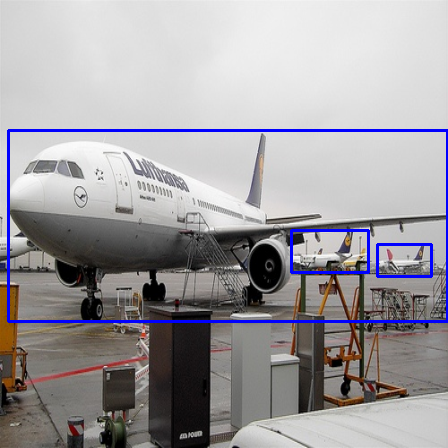

In [53]:
#@title **TODO**: Visualize images with bounding boxes (20 minutes)

# TODO: get an item from the dataset
sample_image, sample_label = train_dataset[3]
# TODO: convert image to numpy array with shape (448, 448 , 3) in the range (0, 255) and type uint8
image = (sample_image.permute(1,2,0) + 1)/2*255. 
image = image.cpu().numpy().astype("uint8")

H, W = image.shape[:2]
# TODO: 1. find the cells in the image grid where there is a bounding box
# 2. get the coordinates of the boxes
# Hint: Use torch.where

box_idx = torch.where(sample_label[:,:,20] == 1)
boxes = sample_label[box_idx[0], box_idx[1]]

#TODO: iterate over the boxes and Compute the global coordinates of the boxes
image = image.copy()
for i in range(len(boxes)):
  # print(boxes[i])
  x_cell, y_cell = boxes[i][21:23]
  width_cell, height_cell = boxes[i][23:25]
  x = x_cell + box_idx[1][i]
  y = y_cell + box_idx[0][i]
  x,y = x/7, y/7
  width = width_cell / 7
  height = height_cell / 7
  x,y = x*H, y * W
  width,height = width*W, height*H
  print(x,y,width, height, W, H)
  image = cv2.rectangle(image, (int(x - width / 2), int(y - height / 2)),
                  (int(x + width / 2), int(y + height / 2)), (0, 0, 255), 2)



Image.fromarray(image)


# Config Model

In [ ]:
#@title **TODO**: CNN Block (10 minutes)

# A CNN Block consists of:
## 1. A convolution layer
## 2. A batch normalization layer
## 3. A activation function. Use LeakyReLU with slop 0.1
class CNNBlock(nn.Module):
  def __init__(self, in_channel, out_channel, **kwargs):
      #in_channel: input channels of the convolution layer
      #out_channel: output channels of the convolution layer
      #kwargs: contains kernel size, stride, padding

      super(CNNBlock, self).__init__()
      self.model = nn.Sequential(
          nn.Conv2d(in_channels=in_channel, 
                  out_channels=out_channel, **kwargs),
          nn.BatchNorm2d(num_features=out_channel),
          nn.LeakyReLU(negative_slope=0.1)
      )

  def forward(self, x):
    return self.model(x)

In [74]:
#@title **TODO**: YOLO Network (30 minutes)


# architecure of the YOLO network
# Tuple :(kernel size, out channels, stirde, padding)
# 'M': 2x2 max pooling
# List: contains Tuples with the same convention mentioned. The last element is number of repetitions

architecture_config = [
    (7, 64, 2, 3),
    'M',
    (3, 192, 1, 1),
    'M',
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    'M',
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    'M',
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

class YOLONet(nn.Module):
  def __init__(self, in_channel = 3, **kwargs):
    super(YOLONet, self).__init__()
    self.in_channel = in_channel
    self.darknet = self._create_conv_layers()
    self.fcs = self._create_fcs(**kwargs)

  def forward(self, x):
    #TODO
    x = self.darknet(x)
    x = torch.flatten(x, start_dim=1)
    x = self.fcs(x)
    return x

  def _create_conv_layers(self):
      #TODO: create Conv layers from the architecture_config list
      layers = []
      in_chanel = self.in_channel
      # A: (7, 64, 2, 3) 7=kernel_size 64=output_chanel_size stride=2 padding=3
      # B: [(1, 256, 1, 0), (3, 512, 1, 1), 4], 4 times of (1, 256, 1, 0) and then (3, 512, 1, 1)
      for layer in architecture_config:
        if layer == "M":
          layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)))
        elif isinstance(layer, tuple): # A
          layers.append(
                  CNNBlock(in_channel=in_chanel, out_channel=layer[1],
                           kernel_size=layer[0], stride=layer[2], 
                           padding=layer[3])
                        )
          in_chanel = layer[1]
        elif isinstance(layer, list):
          conv1 = layer[0]
          conv2 = layer[1]
          repeat = layer[2]
          for _ in range(repeat):
            layers.append(
                  CNNBlock(in_channel=in_chanel, out_channel=conv1[1],
                           kernel_size=conv1[0], stride=conv1[2], 
                           padding=conv1[3])
                        )
            in_chanel = conv1[1] 
            layers.append(
                  CNNBlock(in_channel=in_chanel, out_channel=conv2[1],
                           kernel_size=conv2[0], stride=conv2[2], 
                           padding=conv2[3])
                        )
            in_chanel = conv2[1] 
      
      return nn.Sequential(*layers)    

  def _create_fcs(self, split_size, num_boxes, num_classes):
    S, B, C = split_size, num_boxes, num_classes
    return nn.Sequential(
        nn.Linear(1024 * S * S, 1024),
        nn.LeakyReLU(0.1),
        nn.Linear(1024, S * S * (C + B * 5)),
    )

In [76]:
#@title Test model correctness

model = YOLONet(split_size=7, num_boxes=2, num_classes=20)
input = torch.randn(4, 3, 448, 448)
out = model(input)

assert out.shape == (4, 7 * 7 * (20 + 2 * 5))


# Loss Function

In [77]:
#@title Define loss function
class YoloLoss(nn.Module):
    def __init__(self, S = 7, B = 2, C = 20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction = 'sum')
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim = 0)

        iou_maxes, bestbox = torch.max(ious, dim = 0)
        exists_box = target[..., 20].unsqueeze(3)

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )

        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim = -2),
            torch.flatten(box_targets, end_dim = -2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim = 1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim = 1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim = 1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim = 1),
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim = -2,),
            torch.flatten(exists_box * target[..., :20], end_dim = -2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

# Training

In [ ]:
data_dir = './small_data'
transform = transforms.Compose([
    transforms.Resize((448,448)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = VOCDataset(data_dir = data_dir, transform = transform)

In [88]:
#@title **TODO**: Training script (20 minutes)
class Trainer:
  def __init__(self):
    self.lr = 2e-5
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    self.batch_size = 8
    self.weight_decay = 0.0005

    self.epoch = 100
    self.num_workers = 0
    self.pin_memory = True
    self.load_model = False

    transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                              std=[0.5, 0.5, 0.5])])
    #TODO: Initialize train and test datasets and corresponding DataLoader objects
    self.train_dataset = VOCDataset(data_dir = './small_data', transform = transform, split="train")
    self.trainloader = DataLoader(self.train_dataset, batch_size=self.batch_size,
                                  shuffle=True, pin_memory=self.pin_memory,
                                  drop_last=False)

    self.test_dataset = VOCDataset(data_dir = './small_data', transform = transform, split="test")
    self.testloader = DataLoader(self.test_dataset, batch_size=self.batch_size,
                                  shuffle=False, pin_memory=self.pin_memory,
                                  drop_last=False)

    self.model = YOLONet(split_size=7, num_boxes=2, num_classes=20).to(self.device)
    #TODO: # Define Adam optimizer with model parameters, learning rate, and weight decay
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, 
                                weight_decay=self.weight_decay)
    self.criterion = YoloLoss()

    self.out_dir = './outputs'
    os.makedirs(self.out_dir, exist_ok = True)


  def run(self):
    pbar = tqdm(total = self.epoch, bar_format='{desc}: {percentage:3.0f}% {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]', leave=False)
    for epoch in range(self.epoch):
        if epoch % 10 == 0:
          self.test_step()
        mean_loss = self.train_step()
        pbar.update(1)
        pbar.set_description('Epoch: {}, Mean Loss: {:.4f}'.format(epoch, mean_loss))


  def train_step(self):
    self.model.train()
    mean_loss = []
    for batch_idx, (image, label) in enumerate(self.trainloader):
        image, label = image.to(self.device), label.to(self.device)
        #TODO
        output = self.model(image)
        
        self.optimizer.zero_grad()
        loss = self.criterion(output, label)
        mean_loss.append(loss.item())
        loss.backward()
        self.optimizer.step()

    return sum(mean_loss) / len(mean_loss)

  @torch.no_grad()
  def test_step(self):
    self.model.eval()
    all_pred_boxes = []
    all_true_boxes = []
    sample_idx = 0
    for batch_idx, (image, label) in enumerate(self.testloader):
        image, label = image.to(self.device), label.to(self.device)
        batch_size = image.shape[0]
        preds = self.model(image).reshape(-1, 7, 7, 30)

        true_bboxes = cellboxes_to_boxes(label)
        pred_bboxes = cellboxes_to_boxes(preds)

        for idx in range(batch_size):
            pred_bboxes_nms = non_max_suppression(pred_bboxes[idx])
            for box in pred_bboxes_nms:
                all_pred_boxes.append([sample_idx] + box.tolist())
            for box in true_bboxes[idx]:
                if box[1] > 0:
                    all_true_boxes.append([sample_idx] + box.tolist())
            sample_idx += 1

    self.visualize_results(all_true_boxes, all_pred_boxes)
    return all_pred_boxes, all_true_boxes

  def visualize_results(self, preds, gt):
      for idx in range(len(self.test_dataset)):
          image, _ = self.test_dataset.__getitem__(idx)
          pred_classes = [self.test_dataset.class_names[int(box[1])] for box in preds if box[0] == idx]
          pred_labels = [box for box in preds if box[0] == idx]
          gt_classes = [self.test_dataset.class_names[int(box[1])] for box in gt if box[0] == idx]
          gt_labels = [box for box in gt if box[0] == idx]

          image = draw_boxes_with_labels(image, pred_labels, gt_labels, pred_classes, gt_classes)
          image.save('{}/{}.png'.format(self.out_dir, idx))


In [89]:
trainer = Trainer()
trainer.run()

In [90]:
trainer.test_step()

([[0,
   6.0,
   1.1467198133468628,
   0.6301531195640564,
   0.5753225684165955,
   0.7664324045181274,
   0.884607195854187],
  [1,
   6.0,
   0.9728819131851196,
   0.4167087972164154,
   0.49388813972473145,
   0.49425995349884033,
   0.28214478492736816],
  [2,
   0.0,
   1.090735912322998,
   0.339593768119812,
   0.3770836591720581,
   0.12275582551956177,
   0.1118023544549942],
  [2,
   14.0,
   1.0168765783309937,
   0.06711910665035248,
   0.7578461766242981,
   0.043108828365802765,
   0.17073529958724976],
  [2,
   0.0,
   0.9927855134010315,
   0.4756120443344116,
   0.4765671491622925,
   0.5190578103065491,
   0.34286701679229736],
  [2,
   14.0,
   0.9167957901954651,
   0.38806670904159546,
   0.7181636095046997,
   0.030273225158452988,
   0.16152864694595337],
  [3,
   0.0,
   1.1264755725860596,
   0.5368509292602539,
   0.49835482239723206,
   0.923984706401825,
   0.39237457513809204],
  [3,
   0.0,
   1.0500565767288208,
   0.8963320255279541,
   0.582288265228